In [1]:
#Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

# 5.7 Clustering - solution

Clustering is the task of gathering samples into groups of similar
samples according to some predefined similarity or distance (dissimilarity)
measure, such as the Euclidean distance.
In this section we will explore a basic clustering task on some synthetic and real-world datasets.

Here are some common applications of clustering algorithms:

- Compression for data reduction
- Summarizing data as a reprocessing step for recommender systems
- Similarly:
   - grouping related web news (e.g. Google News) and web search results
   - grouping related stock quotes for investment portfolio management
   - building customer profiles for market analysis
- Building a code book of prototype samples for unsupervised feature extraction

## 5.7.1 Generate a dataset

In [ ]:
#this creates the toy data for the rest of the excercise
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42)
X.shape

In [ ]:
plt.scatter(X[:, 0], X[:, 1]);

In the scatter plot above, we can see three separate groups of data points and we would like to recover them using clustering -- think of "discovering" the class labels that we already take for granted in a classification task.

Even if the groups are obvious in the data, it is hard to find them when the data lives in a high-dimensional space, which we can't visualize in a single histogram or scatterplot.

## 5.7.2 Use KMeans clustering

Now we will use one of the simplest clustering algorithms, K-means.
This is an iterative algorithm which searches for three cluster
centers such that the distance from each point to its cluster is
minimized. The standard implementation of K-means uses the Euclidean distance, which is why we want to make sure that all our variables are measured on the same scale if we are working with real-world datastets. In the previous notebook, we talked about one technique to achieve this, namely, standardization.

**Question:** what would you expect the output to look like?

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)

We can get the cluster labels either by calling fit and then accessing the 
``labels_`` attribute of the K means estimator, or by calling ``fit_predict``.
Either way, the result contains the ID of the cluster that each point is assigned to.

In [ ]:
labels = kmeans.fit_predict(X)

In [ ]:
labels

In [ ]:
y

In [ ]:
# Labels have shifted, create a map for the predicted labels
label_map = {}
label_map[0] = 1
label_map[1] = 2
label_map[2] = 0

In [ ]:
labels= np.array(list(map(lambda x: label_map.get(x), labels)))
labels

Let's visualize the assignments that have been found

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=labels);

Compared to the true labels:

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y);

Here, we are probably satisfied with the clustering results. But in general we might want to have a more quantitative evaluation. How about comparing our cluster labels with the ground truth we got when generating the blobs?

In [ ]:
print('Accuracy score:', accuracy_score(y, labels))
print(confusion_matrix(y, labels))

In [ ]:
np.mean(y == labels)

Even though we recovered the partitioning of the data into clusters perfectly, the cluster IDs we assigned were arbitrary,
and we can not hope to recover them. Therefore, we must use a different scoring metric, such as ``adjusted_rand_score``, which is invariant to permutations of the labels:

In [ ]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(y, labels)

One of the "short-comings" of K-means is that we have to specify the number of clusters, which we often don't know *apriori*. For example, let's have a look what happens if we set the number of clusters to 2 in our synthetic 3-blob dataset:

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels);

## 5.7.3 The Elbow Method

The Elbow method is a "rule-of-thumb" approach to finding the optimal number of clusters. This is done by gradually increasing the number of means (i.e. 'k') and measuring the 'inertia' = the within cluster sum of squares. As soon as this function bottoms out it is reasonably sure that the optimal number for 'k' has been reached. 


Here, we look at the cluster dispersion for different values of k:

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.show()

Then, we pick the value that resembles the "pit of an elbow." As we can see, this would be k=3 in this case, which makes sense given our visual expection of the dataset previously.

## 5.7.4 Pitfalls

**Clustering comes with assumptions**: A clustering algorithm finds clusters by making assumptions with samples should be grouped together. Each algorithm makes different assumptions and the quality and interpretability of your results will depend on whether the assumptions are satisfied for your goal. For K-means clustering, the model is that all clusters have equal, spherical variance.

**In general, there is no guarantee that structure found by a clustering algorithm has anything to do with what you were interested in**.


We can easily create a dataset that has non-isotropic clusters (i.e. the clusters are not directly related to the independent variables you have at hand to describe the data), on which kmeans will fail:

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

y_pred = KMeans(n_clusters=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)

## 5.7.5 Task 5: Salary

Load the datafile 'salary_hours.csv'. It contains data of daily average working hours and their salary. 
- Look at the data, make a scatter plot
- Without any data manipulation, cluster the data. How many clusters will you make? Why?
- Evaluate your model
- Standardize your data, cluster the data again.
- What changed? Why?
- How do you interpret your result?

## 5.7.6 Solution

In [2]:
salary_df = pd.read_csv('data/salary_hours.csv', index_col=0)

In [3]:
salary_df.sample(2)

,salarys,hours
8,1740.898609,10.354322
96,1729.828777,6.881655


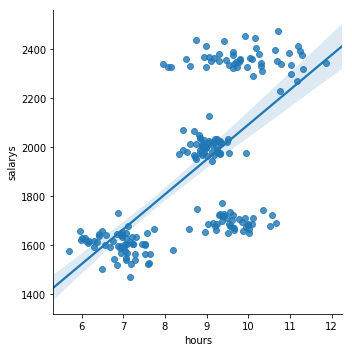

In [4]:
sns.lmplot('hours', 'salarys', data=salary_df)

In [5]:
# Going to make 4 clusters
myKmeans = KMeans(n_clusters=4, random_state=42)

In [6]:
myKmeans.fit(np.array(salary_df))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [7]:
myKmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

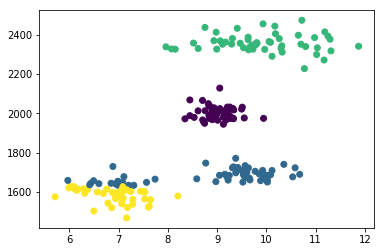

In [8]:
plt.scatter(salary_df['hours'].values, salary_df['salarys'].values, c=myKmeans.labels_);

In [9]:
from sklearn.preprocessing import StandardScaler
salary_np = salary_df.values

In [10]:
mySS = StandardScaler()

In [11]:
salary_std_np = mySS.fit_transform(salary_np)

In [12]:
salary_std_np

array([[-0.70172903,  0.46724735],
       [-0.66131754,  0.86530512],
       [-0.7747715 ,  0.6304226 ],
       [-0.76893139,  1.30940197],
       [-0.66294752,  1.00385976],
       [-0.76203998,  0.59814315],
       [-0.61870733,  0.65419492],
       [-0.55919821,  1.17905949],
       [-0.63099156,  0.49711031],
       [-0.45887597,  0.46629773],
       [-0.60196876,  0.43280329],
       [-0.80164753, -0.11021465],
       [-0.69052729,  0.63123502],
       [-0.84821372,  0.17301325],
       [-0.6110815 ,  0.49689157],
       [-0.53839688,  0.02271078],
       [-0.8200008 ,  0.67771612],
       [-0.7344853 ,  0.58133421],
       [-0.73436157,  0.98247161],
       [-0.7257848 ,  1.4139371 ],
       [-0.80856052,  0.93394319],
       [-0.58150157,  0.60555775],
       [-0.76751653,  0.33746703],
       [-0.72005183,  0.81493422],
       [-0.82290566,  0.35450557],
       [-0.77989608,  0.87700241],
       [-0.74758192,  0.92249212],
       [-0.85509095,  0.93592725],
       [-0.61744893,

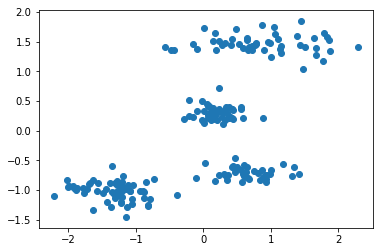

In [13]:
plt.scatter(salary_std_np[:, 1], salary_std_np[:, 0]);

In [14]:
# Going to fit this to the standardized data
myKmeans.fit(salary_std_np)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

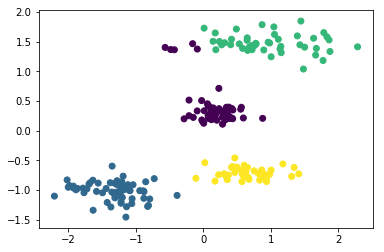

In [15]:
plt.scatter(salary_std_np[:, 1], salary_std_np[:, 0], c=myKmeans.labels_);

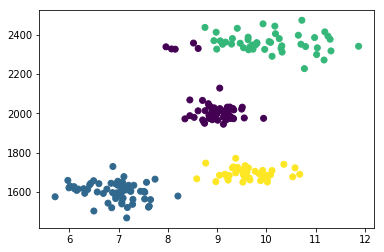

In [16]:
plt.scatter(salary_df['hours'].values, salary_df['salarys'].values, c=myKmeans.labels_);

The result is a more **variable independent** clustering, in the first chart it was clear that the clustering algorithm judged the horizontal distance of points to be of less value than the vertical distance, hence the substantial number of points that were misclassified in the lower left kwadrant. 